In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# neural net model
model = nn.Sequential(nn.Linear(1, 250), nn.Tanh(), nn.Linear(250,1)) 

In [3]:
# initial condition and lambda value
A, lambda_val = 1, 1

# trial solution
u_t = lambda t: A + (1 - torch.exp(-t)) * model(t) 

# function: du/dt + lambda * u = 0 --> du/dt = -lambda * u 
f = lambda t, u: -lambda_val * u 

# random number generator
rng = np.random.default_rng()

In [4]:
def loss(t):

    outputs = u_t(t)
    
    u_t_x = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]
    
    u_tt_x = torch.autograd.grad(u_t_x, t, grad_outputs=torch.ones_like(u_t_x),
                        create_graph=True)[0]
    
    f_t = lambda t, u: -lambda_val * u_t_x

    return torch.mean((u_t_x - f(t, outputs)) ** 2) + 0 * torch.mean((u_tt_x - f_t(t, outputs)) ** 2)

In [5]:
# set-up the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [6]:
iterations = 2000
losses = []
min_x, max_x = 0, 2

# run the training loop
for i in range(iterations):
    # every batch, randomly sample from min and max range
    x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
    x = x[rng.integers(low=0, high=len(x), size=500)]
    x = x.reshape(-1, 1)
    
    # forward: compute loss
    l = loss(x) # forward / compute loss
    losses.append(l.item())
    # backward: backpropagation
    l.backward()
    # update weights and reset the gradients
    optimizer.step() 
    optimizer.zero_grad() 

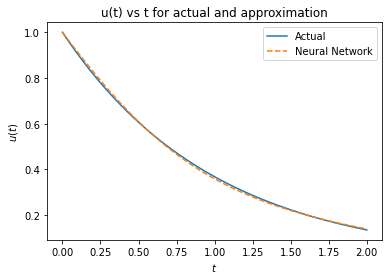

In [7]:
# plot the solution accuracies
xx = np.linspace(0, 2, 200)[:, None]

with torch.no_grad():
    yy = u_t(torch.Tensor(xx)).numpy()

yt = A * np.exp(-lambda_val * xx)

plt.plot(xx, yt, label='Actual')
plt.plot(xx, yy, '--', label='Neural Network')
plt.title("u(t) vs t for actual and approximation")
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
plt.legend(loc='best')
plt.show();

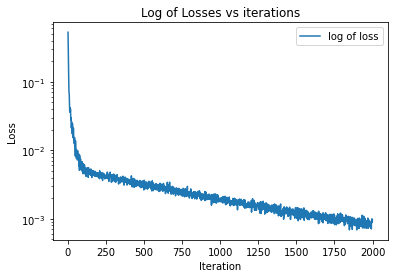

In [8]:
plt.plot(range(iterations), losses, label='log of loss')
plt.yscale("log") # base = 10 
plt.title("Log of Losses vs iterations")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show();